Files already downloaded and verified
Files already downloaded and verified
Using device: cuda

Training model with ProbGate activation
ProbGate - Epoch [10/50]: Train Loss = 0.8739, Val Loss = 0.9348
ProbGate - Epoch [20/50]: Train Loss = 0.6848, Val Loss = 0.8577
ProbGate - Epoch [30/50]: Train Loss = 0.5853, Val Loss = 0.8214
ProbGate - Epoch [40/50]: Train Loss = 0.5258, Val Loss = 0.8315
ProbGate - Epoch [50/50]: Train Loss = 0.4907, Val Loss = 0.8380
ProbGate - Test Accuracy: 76.23%

Training model with ReLU activation
ReLU - Epoch [10/50]: Train Loss = 0.7530, Val Loss = 0.7870
ReLU - Epoch [20/50]: Train Loss = 0.6070, Val Loss = 0.6999
ReLU - Epoch [30/50]: Train Loss = 0.5326, Val Loss = 0.6766
ReLU - Epoch [40/50]: Train Loss = 0.4925, Val Loss = 0.6888
ReLU - Epoch [50/50]: Train Loss = 0.4464, Val Loss = 0.6850
ReLU - Test Accuracy: 79.33%

Training model with GELU activation
GELU - Epoch [10/50]: Train Loss = 0.6328, Val Loss = 0.7460
GELU - Epoch [20/50]: Train Loss = 0.

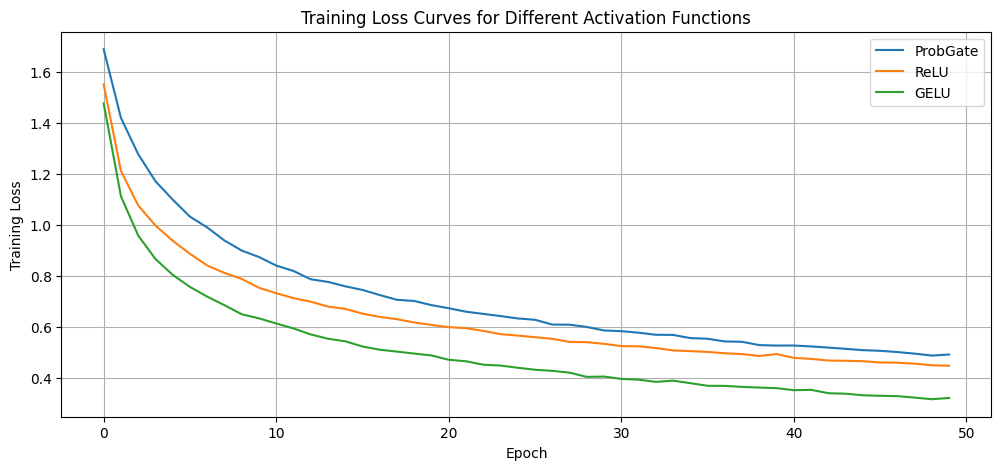

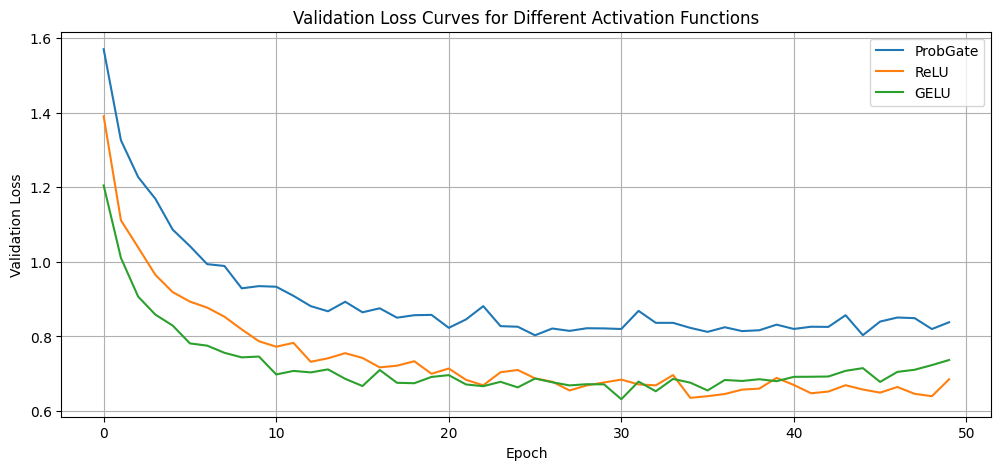


Final Test Accuracies:
ProbGate: 76.23%
ReLU: 79.33%
GELU: 79.52%


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ========================================================
# Define the Probabilistic Gating Activation Function
# ========================================================

class ProbGateFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # Compute a gating probability for each element
        p = torch.sigmoid(x)
        # Sample a binary mask from a Bernoulli distribution with probability p.
        mask = torch.bernoulli(p)
        # Save p for the backward pass.
        ctx.save_for_backward(p, mask)
        # The forward output is x multiplied by the sampled mask.
        return x * mask

    @staticmethod
    def backward(ctx, grad_output):
        # Retrieve saved tensors
        p, mask = ctx.saved_tensors
        # Use a straight-through estimator:
        # Although the forward pass used a hard mask, we approximate the gradient
        # by using the probability p. This means we pass gradients as if the gate
        # were "soft" (i.e. the derivative of the sigmoid is taken into account).
        grad_input = grad_output * p
        return grad_input

class ProbabilisticGate(nn.Module):
    def forward(self, x):
        return ProbGateFunction.apply(x)

# ========================================================
# Define a simple CNN that uses a given activation function.
# ========================================================

class SimpleCNN(nn.Module):
    def __init__(self, activation_fn):
        """
        The activation_fn is used after the convolution layers and on the first fully-connected layer.
        """
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.act1 = activation_fn
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.act2 = activation_fn
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.act_fc = activation_fn  # optional activation after fc1
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        # Apply conv1, activation, and pooling.
        x = self.pool1(self.act1(self.conv1(x)))
        # Apply conv2, activation, and pooling.
        x = self.pool2(self.act2(self.conv2(x)))
        # Flatten feature maps.
        x = x.view(x.size(0), -1)
        # Fully-connected layer with activation.
        x = self.act_fc(self.fc1(x))
        # Final layer (logits for 10 classes)
        x = self.fc2(x)
        return x

# ========================================================
# Data Loading: CIFAR-10 with a training/validation split.
# ========================================================

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

# Download CIFAR-10 training and test datasets.
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split full training set into training (90%) and validation (10%).
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# ========================================================
# Setup Training: Compare ReLU, GELU, and Probabilistic Gating.
# ========================================================

activations = {
    "ProbGate": ProbabilisticGate(),
    "ReLU": nn.ReLU(),
    "GELU": nn.GELU(),
}

epochs = 50  # For demonstration, we train for 50 epochs.
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

train_loss_histories = {}
val_loss_histories = {}
test_accuracies = {}

for act_name, act_fn in activations.items():
    print(f"\nTraining model with {act_name} activation")
    model = SimpleCNN(act_fn).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Evaluate on the validation set.
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"{act_name} - Epoch [{epoch+1}/{epochs}]: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")
    
    train_loss_histories[act_name] = train_losses
    val_loss_histories[act_name] = val_losses
    
    # Evaluate the model on the test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100.0 * correct / total
    test_accuracies[act_name] = test_acc
    print(f"{act_name} - Test Accuracy: {test_acc:.2f}%")

# ========================================================
# Plot training and validation loss curves.
# ========================================================

# Plot training loss curves.
plt.figure(figsize=(12, 5))
for act_name, losses in train_loss_histories.items():
    plt.plot(losses, label=act_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Different Activation Functions")
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss curves.
plt.figure(figsize=(12, 5))
for act_name, losses in val_loss_histories.items():
    plt.plot(losses, label=act_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Different Activation Functions")
plt.legend()
plt.grid(True)
plt.show()

# ========================================================
# Print final test accuracies.
# ========================================================
print("\nFinal Test Accuracies:")
for act_name, acc in test_accuracies.items():
    print(f"{act_name}: {acc:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Using device: cuda

Training deep network with ReLU activation
ReLU - Epoch [10/50]: Train Loss = 0.4858, Val Loss = 0.5747
ReLU - Epoch [20/50]: Train Loss = 0.3254, Val Loss = 0.5352
ReLU - Epoch [30/50]: Train Loss = 0.2664, Val Loss = 0.5343
ReLU - Epoch [40/50]: Train Loss = 0.2248, Val Loss = 0.5454
ReLU - Epoch [50/50]: Train Loss = 0.1961, Val Loss = 0.5572
ReLU - Test Accuracy: 85.83%

Training deep network with GELU activation
GELU - Epoch [10/50]: Train Loss = 0.3416, Val Loss = 0.5103
GELU - Epoch [20/50]: Train Loss = 0.2125, Val Loss = 0.4833
GELU - Epoch [30/50]: Train Loss = 0.1803, Val Loss = 0.5307
GELU - Epoch [40/50]: Train Loss = 0.1573, Val Loss = 0.5661
GELU - Epoch [50/50]: Train Loss = 0.1495, Val Loss = 0.6069
GELU - Test Accuracy: 87.34%

Training deep network with SigmoidWeighted activation
SigmoidWeighted - Epoch [10/50]: Train Loss = 0.3853, Val Loss = 0.5231
SigmoidWeighted - Epoc

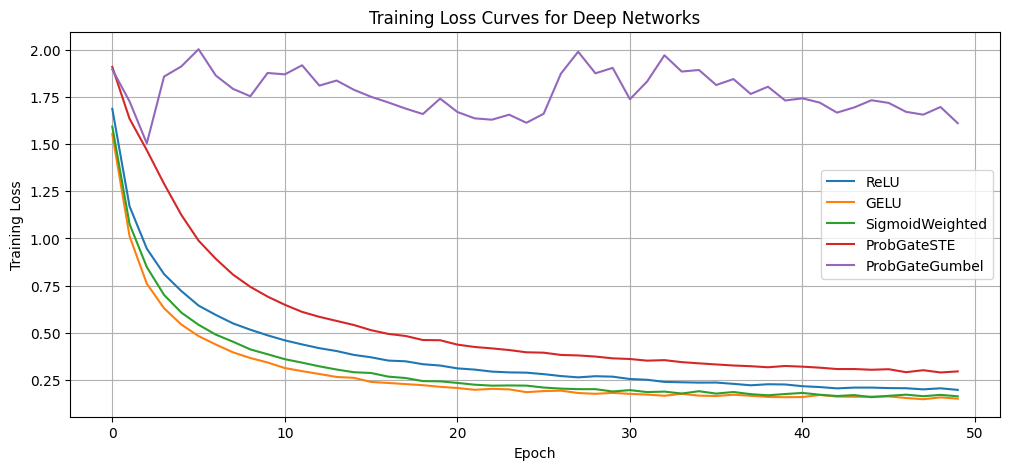

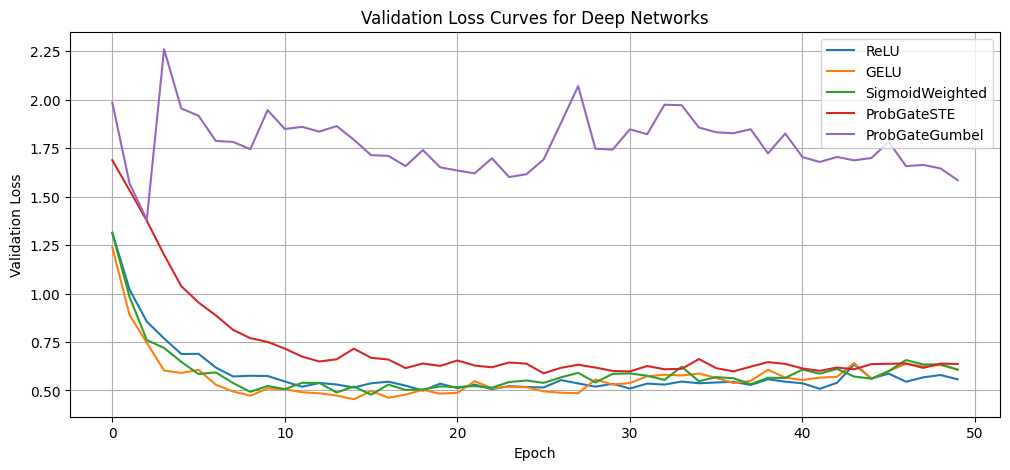


Final Test Accuracies:
ReLU: 85.83%
GELU: 87.34%
SigmoidWeighted: 86.92%
ProbGateSTE: 83.56%
ProbGateGumbel: 44.33%


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ========================================================
# Define Activation Function Variants
# ========================================================

# 1. SigmoidWeighted activation: f(x) = x * sigmoid(x)
class SigmoidWeighted(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# 2. Probabilistic gating using STE.
#    In the forward pass we sample m ~ Bernoulli(sigmoid(x)) and output x * m.
#    In the backward pass we use a straight‐through estimator, approximating the gradient by multiplying by p = sigmoid(x).
class ProbGateSTEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        p = torch.sigmoid(x)
        mask = torch.bernoulli(p)
        ctx.save_for_backward(p)
        return x * mask

    @staticmethod
    def backward(ctx, grad_output):
        (p,) = ctx.saved_tensors
        # STE: pass gradient as if the activation were x * p.
        grad_input = grad_output * p
        return grad_input

class ProbGateSTE(nn.Module):
    def forward(self, x):
        return ProbGateSTEFunction.apply(x)

# 3. Probabilistic gating using the Gumbel-Softmax trick.
#    For each element x, we create a two-class logits vector [0, x].
#    Then we use gumbel_softmax to sample a one-hot vector in a differentiable way.
#    Finally, we use the second entry (corresponding to "1") to gate x.
class ProbGateGumbel(nn.Module):
    def __init__(self, tau=1.0):
        """
        tau: temperature parameter for the Gumbel-Softmax.
        Lower tau makes the distribution more discrete.
        """
        super(ProbGateGumbel, self).__init__()
        self.tau = tau

    def forward(self, x):
        # Create logits for 2 classes for each element.
        # For each element, logits = [0, x] yields probability for class 1 as sigmoid(x).
        # We need to add a new dimension for the two classes.
        logits = torch.stack([torch.zeros_like(x), x], dim=-1)  # shape: (..., 2)
        # Apply gumbel_softmax with hard sampling.
        # This returns a one-hot vector (but with a soft gradient thanks to the continuous relaxation).
        sample = F.gumbel_softmax(logits, tau=self.tau, hard=True, dim=-1)
        # Use the second component (index 1) as the gate.
        gate = sample[..., 1]
        return x * gate

# ========================================================
# Define a Deep CNN Architecture
# ========================================================
class DeepCNNWithActivation(nn.Module):
    def __init__(self, activation_fn):
        """
        A deep CNN with three convolutional blocks.
        Each block contains two convolutional layers followed by a pooling layer.
        The given activation_fn (an nn.Module) is applied elementwise after each convolution.
        """
        super(DeepCNNWithActivation, self).__init__()
        # Block 1: Input 32x32 -> 16x16
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.act1 = activation_fn
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.act2 = activation_fn
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2: 16x16 -> 8x8
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act3 = activation_fn
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.act4 = activation_fn
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3: 8x8 -> 4x4
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act5 = activation_fn
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.act6 = activation_fn
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers.
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.act_fc = activation_fn
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # Block 1.
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.pool1(x)
        # Block 2.
        x = self.act3(self.conv3(x))
        x = self.act4(self.conv4(x))
        x = self.pool2(x)
        # Block 3.
        x = self.act5(self.conv5(x))
        x = self.act6(self.conv6(x))
        x = self.pool3(x)
        # Flatten and apply fully connected layers.
        x = x.view(x.size(0), -1)
        x = self.act_fc(self.fc1(x))
        x = self.fc2(x)
        return x

# ========================================================
# Data Preparation: CIFAR-10 Training/Validation/Test Split
# ========================================================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training set: 90% train, 10% validation.
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# ========================================================
# Training Settings and Model Comparison
# ========================================================
epochs = 50   # Adjust epochs as needed.
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define a dictionary with the activation variants to compare.
activations = {
    "ReLU": nn.ReLU(),
    "GELU": nn.GELU(),
    "SigmoidWeighted": SigmoidWeighted(),
    "ProbGateSTE": ProbGateSTE(),
    "ProbGateGumbel": ProbGateGumbel(tau=1.0)  # You can adjust tau if desired.
}

# We'll use the same deep CNN architecture (DeepCNNWithActivation) and swap in each activation.
models = {}
for name, act in activations.items():
    models[name] = DeepCNNWithActivation(act)

# Move models to device.
for name in models:
    models[name] = models[name].to(device)

train_loss_histories = {}
val_loss_histories = {}
test_accuracies = {}

# ========================================================
# Training Loop for Each Activation Variant
# ========================================================
for model_name, model in models.items():
    print(f"\nTraining deep network with {model_name} activation")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Evaluate on validation set.
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"{model_name} - Epoch [{epoch+1}/{epochs}]: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")
    
    train_loss_histories[model_name] = train_losses
    val_loss_histories[model_name] = val_losses

    # Evaluate on test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100.0 * correct / total
    test_accuracies[model_name] = test_acc
    print(f"{model_name} - Test Accuracy: {test_acc:.2f}%")

# ========================================================
# Plot Training and Validation Loss Curves
# ========================================================
plt.figure(figsize=(12, 5))
for model_name, losses in train_loss_histories.items():
    plt.plot(losses, label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Deep Networks")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for model_name, losses in val_loss_histories.items():
    plt.plot(losses, label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Deep Networks")
plt.legend()
plt.grid(True)
plt.show()

# ========================================================
# Print Final Test Accuracies
# ========================================================
print("\nFinal Test Accuracies:")
for model_name, acc in test_accuracies.items():
    print(f"{model_name}: {acc:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Using device: cuda

Training very deep network with ReLU activation
ReLU - Epoch [10/100]: Train Loss = 0.6035, Val Loss = 0.6882
ReLU - Epoch [20/100]: Train Loss = 0.4101, Val Loss = 0.5331
ReLU - Epoch [30/100]: Train Loss = 0.3329, Val Loss = 0.5310
ReLU - Epoch [40/100]: Train Loss = 0.2940, Val Loss = 0.5082
ReLU - Epoch [50/100]: Train Loss = 0.2688, Val Loss = 0.5088
ReLU - Epoch [60/100]: Train Loss = 0.2572, Val Loss = 0.5112
ReLU - Epoch [70/100]: Train Loss = 0.2484, Val Loss = 0.4890
ReLU - Epoch [80/100]: Train Loss = 0.2322, Val Loss = 0.4983
ReLU - Epoch [90/100]: Train Loss = 0.2092, Val Loss = 0.5344
ReLU - Epoch [100/100]: Train Loss = 0.2200, Val Loss = 0.5379
ReLU - Test Accuracy: 85.33%

Training very deep network with GELU activation
GELU - Epoch [10/100]: Train Loss = 0.4834, Val Loss = 0.5466
GELU - Epoch [20/100]: Train Loss = 0.3252, Val Loss = 0.4389
GELU - Epoch [30/100]: Train Loss

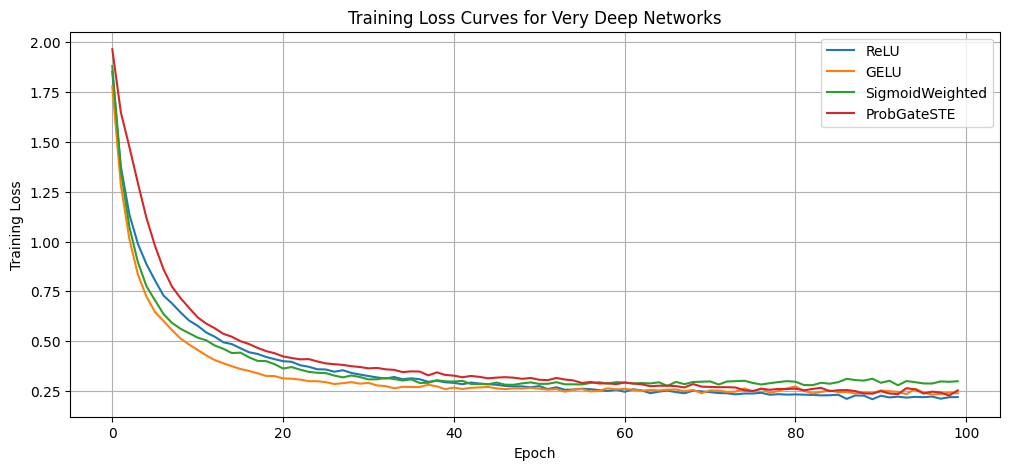

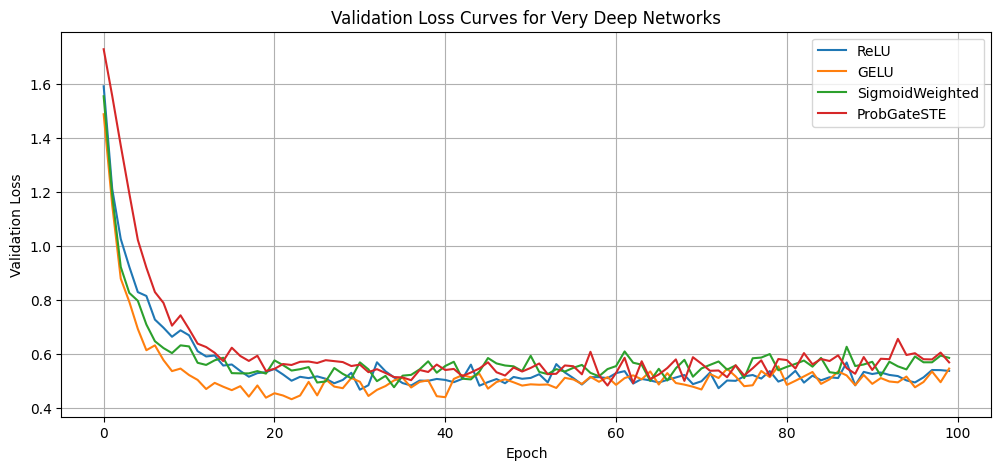


Final Test Accuracies:
ReLU: 85.33%
GELU: 86.02%
SigmoidWeighted: 85.22%
ProbGateSTE: 85.49%


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# ========================================================
# Custom Activation Modules
# ========================================================

# SigmoidWeighted activation: f(x) = x * sigmoid(x)
class SigmoidWeighted(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

# ProbGateSTE using a straight-through estimator:
# In the forward pass, sample m ~ Bernoulli(sigmoid(x)) and output x * m.
# In the backward pass, pass the gradient multiplied by sigmoid(x).
class ProbGateSTEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        p = torch.sigmoid(x)
        mask = torch.bernoulli(p)
        ctx.save_for_backward(p)
        return x * mask

    @staticmethod
    def backward(ctx, grad_output):
        (p,) = ctx.saved_tensors
        # Use the STE: treat the forward pass as if the output were x * p.
        grad_input = grad_output * p
        return grad_input

class ProbGateSTE(nn.Module):
    def forward(self, x):
        return ProbGateSTEFunction.apply(x)

# ========================================================
# Define a Very Deep CNN Architecture
# ========================================================
class VeryDeepCNN(nn.Module):
    def __init__(self, activation_fn):
        """
        This network has 3 blocks.
        Each block contains 3 convolutional layers (with the chosen activation)
        and then a 2x2 max pooling to downsample.
        With CIFAR-10 (32x32 inputs), after three poolings we get a 4x4 feature map.
        This "very deep" architecture is designed to stress test the effect of different
        activation functions on gradient flow and regularization.
        """
        super(VeryDeepCNN, self).__init__()
        
        # Block 1: Input 32x32, output remains 32x32, then pooling to 16x16.
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.act1_1  = activation_fn
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.act1_2  = activation_fn
        self.conv1_3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.act1_3  = activation_fn
        self.pool1   = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 2: 16x16 -> (16x16) then pooling -> 8x8.
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.act2_1  = activation_fn
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.act2_2  = activation_fn
        self.conv2_3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.act2_3  = activation_fn
        self.pool2   = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Block 3: 8x8 -> (8x8) then pooling -> 4x4.
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.act3_1  = activation_fn
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.act3_2  = activation_fn
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.act3_3  = activation_fn
        self.pool3   = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers.
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.act_fc = activation_fn  # apply activation after fc1
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        # Block 1
        x = self.act1_1(self.conv1_1(x))
        x = self.act1_2(self.conv1_2(x))
        x = self.act1_3(self.conv1_3(x))
        x = self.pool1(x)
        
        # Block 2
        x = self.act2_1(self.conv2_1(x))
        x = self.act2_2(self.conv2_2(x))
        x = self.act2_3(self.conv2_3(x))
        x = self.pool2(x)
        
        # Block 3
        x = self.act3_1(self.conv3_1(x))
        x = self.act3_2(self.conv3_2(x))
        x = self.act3_3(self.conv3_3(x))
        x = self.pool3(x)
        
        # Flatten and fully connected layers.
        x = x.view(x.size(0), -1)
        x = self.act_fc(self.fc1(x))
        x = self.fc2(x)
        return x

# ========================================================
# Data Preparation: CIFAR-10 with Training/Validation/Test Splits
# ========================================================
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010]),
])

full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split training into 90% train and 10% validation.
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# ========================================================
# Training Setup and Model Comparison
# ========================================================
epochs = 100
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Define activation variants to compare.
activation_variants = {
    "ReLU": nn.ReLU(),
    "GELU": nn.GELU(),
    "SigmoidWeighted": SigmoidWeighted(),
    "ProbGateSTE": ProbGateSTE()
}

# Instantiate a very deep network for each activation variant.
models = {}
for name, act in activation_variants.items():
    models[name] = VeryDeepCNN(act)
    
# Move models to the device.
for name in models:
    models[name] = models[name].to(device)

train_loss_histories = {}
val_loss_histories = {}
test_accuracies = {}

# ========================================================
# Training Loop for Each Activation Variant
# ========================================================
for model_name, model in models.items():
    print(f"\nTraining very deep network with {model_name} activation")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * images.size(0)
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Evaluate on validation set.
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"{model_name} - Epoch [{epoch+1}/{epochs}]: Train Loss = {epoch_train_loss:.4f}, Val Loss = {epoch_val_loss:.4f}")
    
    train_loss_histories[model_name] = train_losses
    val_loss_histories[model_name] = val_losses
    
    # Evaluate on test set.
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = 100.0 * correct / total
    test_accuracies[model_name] = test_acc
    print(f"{model_name} - Test Accuracy: {test_acc:.2f}%")

# ========================================================
# Plot Training Loss Curves
# ========================================================
plt.figure(figsize=(12, 5))
for model_name, losses in train_loss_histories.items():
    plt.plot(losses, label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss Curves for Very Deep Networks")
plt.legend()
plt.grid(True)
plt.show()

# ========================================================
# Plot Validation Loss Curves
# ========================================================
plt.figure(figsize=(12, 5))
for model_name, losses in val_loss_histories.items():
    plt.plot(losses, label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves for Very Deep Networks")
plt.legend()
plt.grid(True)
plt.show()

# ========================================================
# Print Final Test Accuracies
# ========================================================
print("\nFinal Test Accuracies:")
for model_name, acc in test_accuracies.items():
    print(f"{model_name}: {acc:.2f}%")


In [10]:
!rm -rf gpt2_*

In [11]:
!nvidia-smi

Sat Feb  8 19:01:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40S                    On  |   00000000:64:00.0 Off |                    0 |
| N/A   44C    P0             84W /  350W |    5723MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----